In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
sys.path.append("..")
from tqdm import tqdm

plt.style.use("../config/custom_plt.mplstyle")

In [2]:
labels = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/citeseer.content", 
                     sep="\t", header=None)
labels.columns = ['id', *[f'f{i}' for i in range(3703)], 'label']

labels = labels[['id', 'label']]
labels.head()

/tmp/ipykernel_3512732/222261418.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  labels = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/citeseer.content",


,id,label
0,100157,Agents
1,100598,IR
2,105684,Agents
3,11099,DB
4,114091,AI


In [3]:
categories = labels['label'].unique()
colormap = cm.get_cmap('Set1', len(categories))

/tmp/ipykernel_3512732/3370728750.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Set1', len(categories))


In [4]:
category_to_colormap = dict(zip(categories, range(len(categories))))
category_to_colormap

{'Agents': 0, 'IR': 1, 'DB': 2, 'AI': 3, 'HCI': 4, 'ML': 5}

## Exploring node features

In [5]:
from sklearn.metrics.pairwise import *

features = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/citeseer.content", 
                     sep="\t", header=None)
features.columns = ['id', *[f'f{i}' for i in range(3703)], 'label']
features.drop('label', axis=1, inplace=True)
features.head()

/tmp/ipykernel_3512732/3179688440.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  features = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/citeseer.content",


,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f3693,f3694,f3695,f3696,f3697,f3698,f3699,f3700,f3701,f3702
0,100157,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,100598,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,105684,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11099,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,114091,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
import networkx as nx

g = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/citeseer_GC_fixed.edge")
# g = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/citeseer/citeseer.cites")
gcc_edges_idx = list(g.nodes)

gcc_edges_idx.sort()
gcc_edges_idx[:5]

['100157', '100598', '104129', '106003', '106339']

In [7]:
data = features.merge(labels, on="id")
data.id = data.id.astype(str)

# Remove the nodes which are in the edgelist but not in feature set
data = data[data.id.isin(gcc_edges_idx)] # only take GCC

data.head()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f3694,f3695,f3696,f3697,f3698,f3699,f3700,f3701,f3702,label
0,100157,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Agents
1,100598,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,IR
3,11099,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,DB
4,114091,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,AI
5,11510,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,AI


In [8]:
idx = pd.Series(gcc_edges_idx)
print(len(idx))
nodes_to_remove = idx[~idx.isin(data.id.values)]
print(len(nodes_to_remove))
nodes_to_remove

2110
0


Series([], dtype: object)

In [9]:
g.remove_nodes_from(nodes_to_remove)

In [10]:
print(g)

Graph with 2110 nodes and 3668 edges


In [11]:
# nx.write_edgelist(g, "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/citeseer/citeseer_fixed.edge", data=False)

## Dimensional reduction of the nodes' features using UMAP

In [12]:
from sklearn import preprocessing
from sklearn.utils import shuffle


X = data.drop(["id", "label"], axis=1).values

#y = data['label'].values
le = preprocessing.LabelEncoder()
y = le.fit_transform(data['label'].values)

X[:5], y[:5]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([1, 4, 2, 0, 0]))

In [14]:
np.mean(X.sum(axis=1))

32.065876777251184

In [13]:
%%time
from sklearn.model_selection import train_test_split
from umap.umap_ import UMAP
np.random.seed(12)

reducer = UMAP(metric='cosine', random_state=61)

X_umap = reducer.fit_transform(X)
X_umap.shape

CPU times: user 21.8 s, sys: 834 ms, total: 22.6 s
Wall time: 23.6 s


(2110, 2)

Text(0.5, 1.0, 'UMAP dim=2')

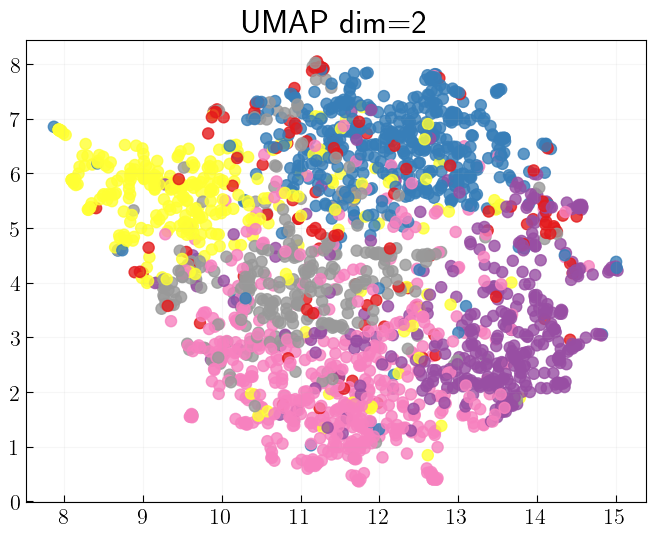

In [14]:
from matplotlib.lines import Line2D

plt.scatter(X_umap[:, 0], X_umap[:, 1], color=[colormap(i) for i in y], alpha=0.8)
plt.title('UMAP dim=2')

### Check non-euclidean embeddings

https://umap-learn.readthedocs.io/en/latest/embedding_space.html

**Spherical embeddings**

In [15]:
sphere_mapper = UMAP(metric='cosine', output_metric='haversine', random_state=61).fit(X) 

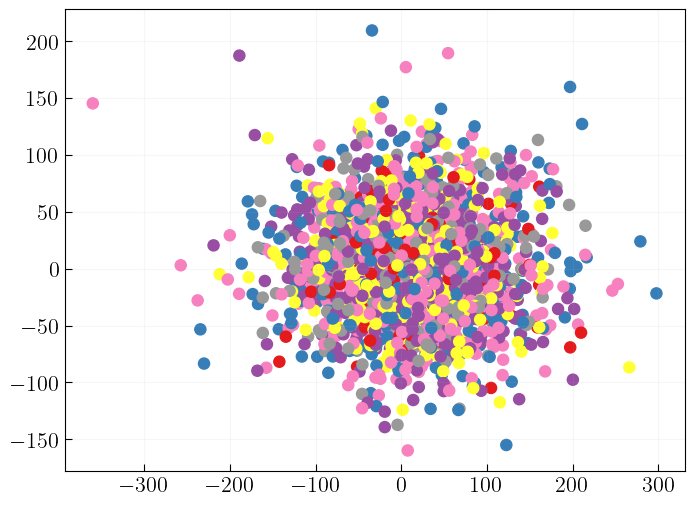

In [16]:
plt.scatter(sphere_mapper.embedding_.T[0], sphere_mapper.embedding_.T[1], c=[colormap(i) for i in y])

In [17]:
xx = np.sin(sphere_mapper.embedding_[:, 0]) * np.cos(sphere_mapper.embedding_[:, 1])
yy = np.sin(sphere_mapper.embedding_[:, 0]) * np.sin(sphere_mapper.embedding_[:, 1])
zz = np.cos(sphere_mapper.embedding_[:, 0])

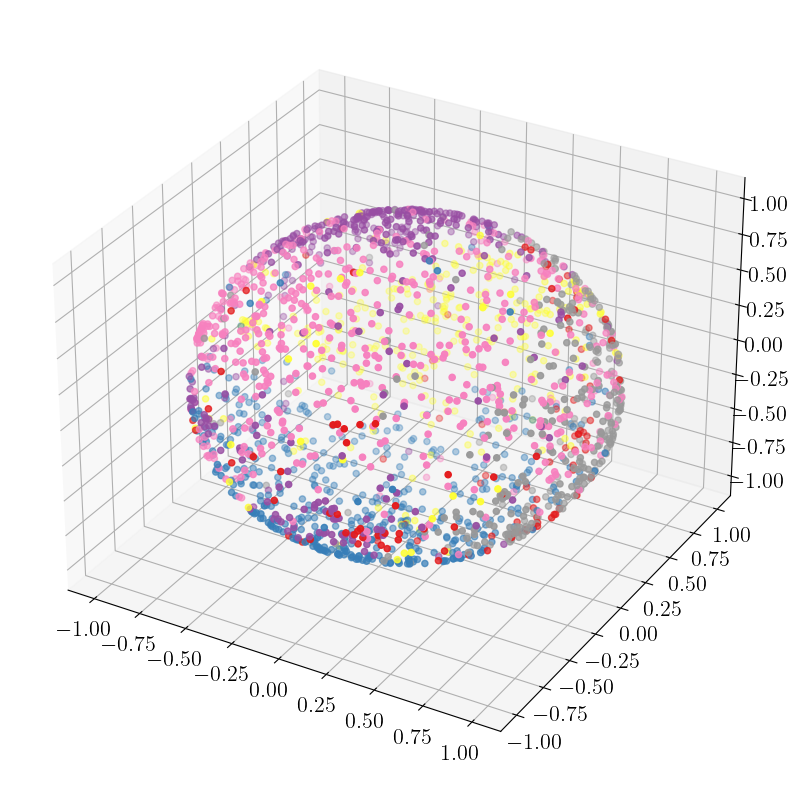

In [18]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx, yy, zz, c=[colormap(i) for i in y])

In [19]:
vectors = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1), zz.reshape(-1, 1)), axis=1)

In [20]:
idx = data['id'].values
idx
# np.c_[idx, vectors]

array(['100157', '100598', '11099', ..., 'zavrel00information',
       'zhang01maximum', 'zhang01pvm'], dtype=object)

In [21]:
vectors

array([[-0.37165248,  0.17228265, -0.9122462 ],
       [ 0.99398285, -0.10708079,  0.02306293],
       [ 0.92430294, -0.321437  ,  0.20577253],
       ...,
       [ 0.78919125, -0.47628418,  0.38772488],
       [-0.08260251, -0.3937219 ,  0.9155107 ],
       [-0.7925446 ,  0.3652945 ,  0.48829606]], dtype=float32)

In [22]:
# with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/citeseer/umap/only_gcc/umap_citeseer_spherical_positions_only_gcc.txt", 'w') as f:
#     for i, v in zip(idx, vectors):
#         f.write(f'{i} {" ".join(map(str, v))}\n')

In [23]:
# with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/citeseer/umap/all/umap_citeseer_spherical_positions_all.txt", 'w') as f:
#     for i, v in zip(idx, vectors):
#         f.write(f'{i} {" ".join(map(str, v))}\n')

In [24]:
## F-Mercator

# with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/umap/umap_citeseer_spherical_positions_gcc.txt", 'w') as f:
#     for i, v in zip(idx, vectors):
#         f.write(f'{i} {" ".join(map(str, v))}\n')

In [54]:
%%time

sphere_mapper = UMAP(metric='cosine', output_metric='haversine', random_state=2).fit(X)
xx = np.sin(sphere_mapper.embedding_[:, 0]) * np.cos(sphere_mapper.embedding_[:, 1])
yy = np.sin(sphere_mapper.embedding_[:, 0]) * np.sin(sphere_mapper.embedding_[:, 1])
zz = np.cos(sphere_mapper.embedding_[:, 0])
vectors2 = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1), zz.reshape(-1, 1)), axis=1)

CPU times: user 22.6 s, sys: 454 ms, total: 23.1 s
Wall time: 22.6 s


In [55]:
# with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/umap_1/umap_citeseer_spherical_positions_gcc_1.txt", 'w') as f:
#     for i, v in zip(idx, vectors2):
#         f.write(f'{i} {" ".join(map(str, v))}\n')

100%|██████████| 2110/2110 [04:43<00:00,  7.45it/s]


The best Z-axis rotation angle:  5.257359134578837


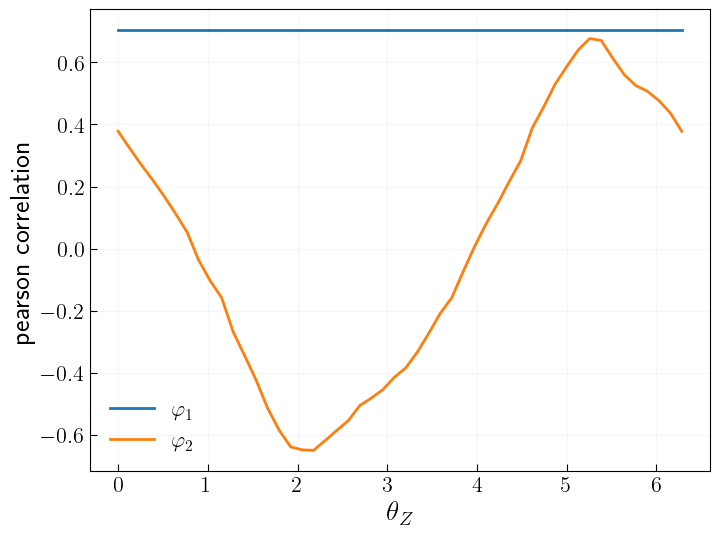

In [32]:
from lib.check_inferred_embeddings import *

real_coords_all, inf_coords_all, real_coords_spherical, inf_coords_spherical = \
    apply_pipeline_matrix_with_loading_and_rotate_all_euclidean_use_all_nodes(vectors, vectors2)

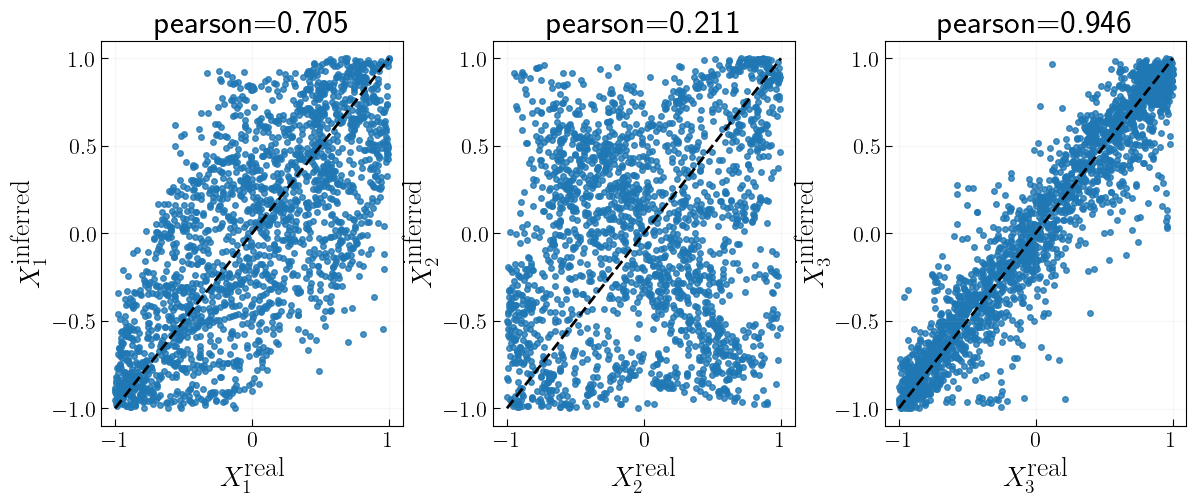

In [33]:
plot_euclidean_coordinates_comparison(inf_coords_all, real_coords_all)

In [34]:
%%time

sphere_mapper1 = UMAP(metric='cosine', output_metric='haversine', random_state=3).fit(X)
xx1 = np.sin(sphere_mapper1.embedding_[:, 0]) * np.cos(sphere_mapper1.embedding_[:, 1])
yy1 = np.sin(sphere_mapper1.embedding_[:, 0]) * np.sin(sphere_mapper1.embedding_[:, 1])
zz1 = np.cos(sphere_mapper1.embedding_[:, 0])
vectors1 = np.concatenate((xx1.reshape(-1, 1), yy1.reshape(-1, 1), zz1.reshape(-1, 1)), axis=1)

CPU times: user 23 s, sys: 356 ms, total: 23.3 s
Wall time: 23.1 s


In [37]:
%%time

sphere_mapper2 = UMAP(metric='cosine', output_metric='haversine', random_state=4).fit(X)
xx2 = np.sin(sphere_mapper2.embedding_[:, 0]) * np.cos(sphere_mapper2.embedding_[:, 1])
yy2 = np.sin(sphere_mapper2.embedding_[:, 0]) * np.sin(sphere_mapper2.embedding_[:, 1])
zz2 = np.cos(sphere_mapper2.embedding_[:, 0])
vectors22 = np.concatenate((xx2.reshape(-1, 1), yy2.reshape(-1, 1), zz2.reshape(-1, 1)), axis=1)

CPU times: user 23.7 s, sys: 308 ms, total: 24 s
Wall time: 23.7 s


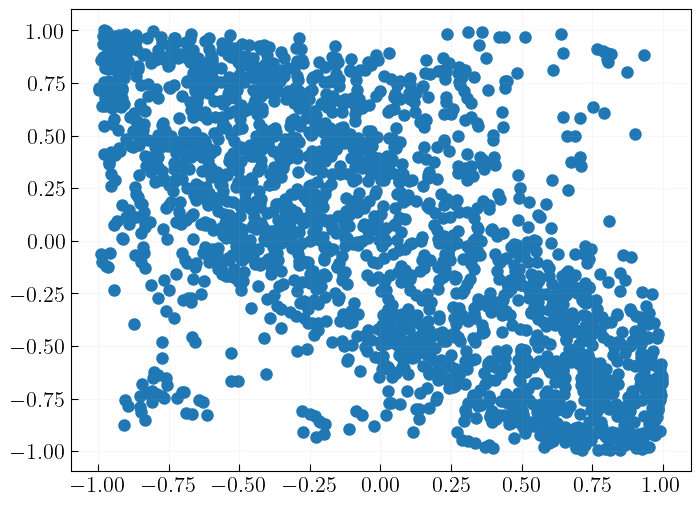

In [40]:
plt.scatter(xx1, xx2)

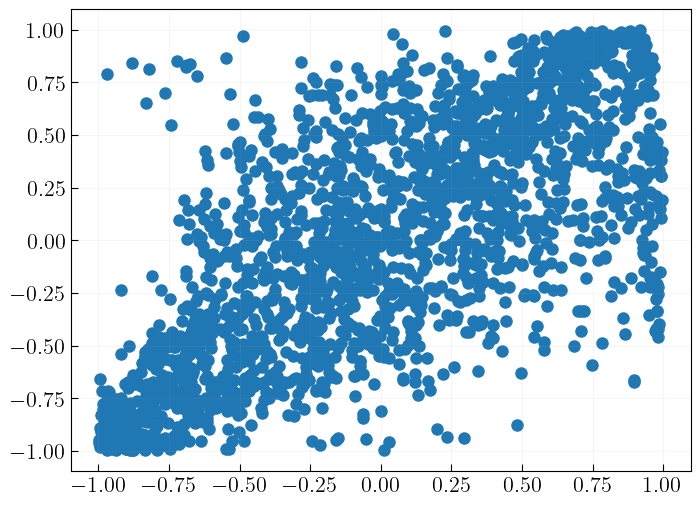

In [41]:
plt.scatter(yy1, yy2)

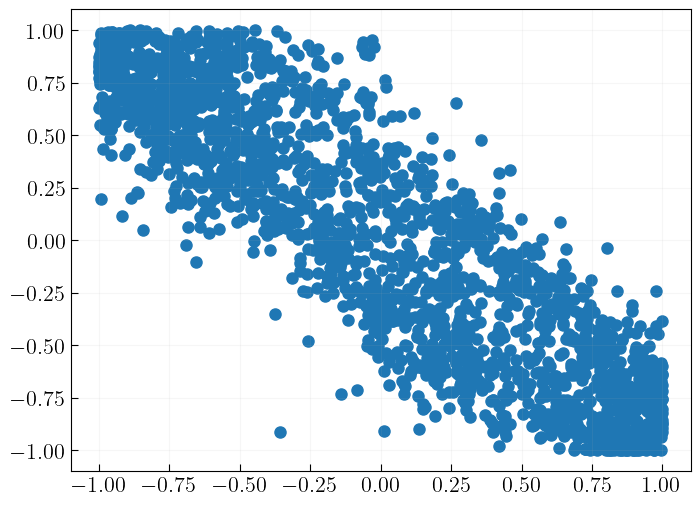

In [42]:
plt.scatter(zz1, zz2)